# 互评作业2：频繁模式与关联规则

运行此notebook需要使用matplotlib库。注意，加载数据集需要占用约4GB内存。

## 0 数据集简介及任务说明

本次互评作业使用的数据集是Chicago Building Violations。本数据集包含芝加哥从2006年到2019年所开具的建筑违规罚单。这些罚单记录了罚单的ID、产生日期、最后修改日期、违规的具体情形、建筑地址等等信息。数据集中记录了每一列的意义，如下所示：

In [1]:
import matplotlib.pyplot as plt
import json
import csv
from collections import defaultdict

fjson = open("Chicago Building Violations/socrata_metadata.json")

json_data=json.load(fjson)
print('#\tcolumn')
for column in json_data['columns']:
    print(column['position']-1,end='\t')
    print(column['name'])
    if 'description' in column:
        print('\t\t'+column['description'])
        
# 数据集有些大，进行一些清理工作以节约内存
del json_data
fjson.close()

#	column
0	ID
1	VIOLATION LAST MODIFIED DATE
2	VIOLATION DATE
		The date the violation was cited.
3	VIOLATION CODE
		The Violation Code. See Violation Description for the description of what the code means.
4	VIOLATION STATUS
		Complied = Violations have been addressed;
Open = Violations are open;
No Entry = Inspector could not gain access to the premise to conduct an inspection.
5	VIOLATION STATUS DATE
6	VIOLATION DESCRIPTION
		The description of the violation corresponding to the Violation Code value.
7	VIOLATION LOCATION
8	VIOLATION INSPECTOR COMMENTS
9	VIOLATION ORDINANCE
10	INSPECTOR ID
11	INSPECTION NUMBER
12	INSPECTION STATUS
13	INSPECTION WAIVED
14	INSPECTION CATEGORY
		Inspections are categorized by one of the following: COMPLAINT – Inspection is a result of a 311 Complaint. PERIODIC – Inspection is a result of recurring inspection (typically on an annual cycle). PERMIT – Inspection is a result of a permit. REGISTRATION – Inspection is a result of a Registration (typically Vac

接下来介绍我们讨论的主要问题。我们先统计记录的个数以及涉及房屋的数量：

In [2]:
def read_csv(filename):
    with open(filename) as f:
        csv_content = csv.reader(f)
        columns = next(csv_content)
        rows = [row for row in csv_content]
    return columns, rows

# 对标称值计数以及画条形图
def count_occurence(data,column,ignore_empty=True):
    '''统计数据某个特定列中所有元素的出现次数，返回一个dict-like
    如果置ignore-empty为True，则返回的字典中不包含空值的计数'''
    count = defaultdict(int)
    for row in data:
        if ignore_empty and row[column]=='':
            continue
        count[row[column]]+=1
    return count

cols_csv,rows_csv = read_csv('Chicago Building Violations/building-violations.csv')
print(f'数据集中有{len(rows_csv)}条记录')
addr_occurence=count_occurence(rows_csv,16,False)
assert '' not in addr_occurence # 显然，数据集中每一条记录都是有对应房屋地址的
print(f'数据集涉及{len(addr_occurence)}个房屋地址')

数据集中有1677788条记录
数据集涉及154007个房屋地址


可见数据集中涉及房屋地址的数量比罚单数量少一个数量级左右，因此本次互评作业的任务是探究房屋开具罚单（确切地说，罚单类型）的模式和关联关系。

## 1 数据的预处理

接下来，我们对数据集进行一些预处理，仅保留我们需要的内容。我们想要保留的数据只有两类：1）违规代码与其解释的对应关系；2）每个房屋产生过哪些违规罚单。为了节约内存，我们忽略掉其他部分。

In [3]:
# 违规代码到对应解释的映射关系
viol2code=[]
viol2desp=[]
code2viol={}
# 建筑物到其地址的关系
bld2addr=[]
addr2bld={}
# 建筑物ID到其产生的罚单表的关系
bld2viols=[]
for row in rows_csv:
    # 整理违规代码对应的解释
    code = row[3]
    desp = row[6]
    violid=-1
    if code in code2viol:
        violid=code2viol[code]
    else:
        violid = len(viol2code)
        viol2code.append(code)
        viol2desp.append(desp)
        code2viol[code]=violid
    # 整理建筑物罚单
    addr = row[16]
    bldid = -1
    if addr in addr2bld:
        bldid = addr2bld[addr]
    else:
        bldid = len(bld2addr)
        bld2addr.append(addr)
        bld2viols.append([])
        addr2bld[addr]=bldid
    bld2viols[bldid].append(violid)
# 原始数据量很大，故删除之以节省内存
del rows_csv
del addr2bld
del code2viol

我们来看一下每个建筑物对应的罚单数量的分布情况：

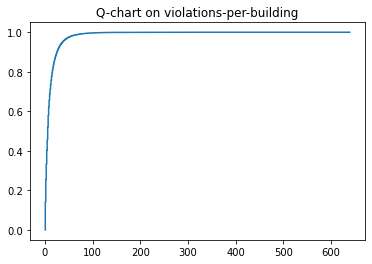

In [4]:
viol_count=sorted([len(l)for l in bld2viols])

def plot_qchart(values,title='Q-chart',extra_sort=True):
    count = len(values)
    plotted_vals = sorted(values) if extra_sort else values
    plt.figure()
    plt.title(title)
    plt.plot(plotted_vals,[i/count for i in range(count)])
    plt.show()

bld_count = len(viol_count)
plot_qchart(viol_count,'Q-chart on violations-per-building',False)

从上述统计看，绝大多数建筑只有很少（不到50个）的罚单，但个别建筑有很多罚单。

## 2 频繁模式统计

现在我们统计这对关系中的频繁模式。我们使用Apriori方法找到所有的频繁模式：

In [5]:
min_support=.07
buildings = len(bld2viols)
abssup_min = int(min_support*buildings)

#Apriori算法的原实现来自
#https://blog.csdn.net/qq_39872846/article/details/105291265
#使用时有改动

# 求第一次扫描数据库后的候选集
# 就是求这个数据库中出现了几个元素，然后返回
def item(dataset):
    print('首次扫描……')
    s1=set()
    for x in dataset:
        for y in x:
            s1.add(y)
    return sorted([[y] for y in s1])

# 求第k次候选集
def get_candidate(Fk, K):
    print(f'\n求第{K}次扫描的候选集……')
    ck = []    #存放产生候选集

    for i in range(len(Fk)):
        for j in range(i+1, len(Fk)):
            L1 = list(Fk[i])[:K-2]
            L2 = list(Fk[j])[:K-2]
            L1.sort()
            L2.sort() #先排序，在进行组合

            if L1 == L2:
                if K > 2:
                    new = list(set(Fk[i]) ^ set(Fk[j]) )
                else:
                    new = set()
                for x in Fk: 
                    #剪枝：new是 x 的子集，并且 还没有加入 ck 中
                    if set(new).issubset(set(x)) and list(set(Fk[i]) | set(Fk[j])) not in ck: 
                        ck.append( list(set(Fk[i]) | set(Fk[j])) )
    return ck

def get_frequent_item(dataset, c, min_support):
    cut_branch = {}     #用来存放所有项集的支持度的字典
    lc=len(c)
    for i,x in enumerate(c):
        setx=set(x)
        for y in dataset:
            if setx.issubset(set(y)):     #如果 x 在 y中，就把对应元素后面加 1
                cut_branch[tuple(x)] = cut_branch.get(tuple(x), 0) + 1
                #cut_branch[y] = new_cand.get(y, 0)表示如果字典里面没有想要的关键词，就返回0
        print(f'\r计算支持度：{i}/{lc}            ',end='')

    Fk = []       #支持度大于最小支持度的项集，  即频繁项集
    sup_dataK = {}  #用来存放所有 频繁 项集的支持度的字典

    for i in cut_branch:
        if cut_branch[i] >= min_support:
            Fk.append( list(i))
            sup_dataK[i] = cut_branch[i]
    return Fk, sup_dataK

# 此方法有两个返回值：
# F是一个三维列表，第0维是历次迭代产生的频繁项集，第1维是各个频繁项集，第2维是集合中的各个项
# sup是一个字典，键是各个频繁项集，值是频繁项集对应的绝对support
def Apriori(dataset, min_support = 2):
    c1 = item (dataset) #返回一个二维列表，里面的每一个一维列表，都是第一次候选集的元素
    f1, sup_1 = get_frequent_item(dataset, c1, min_support)       #求第一次候选集

    F = [f1]      #将第一次候选集产生的频繁项集放入 F ,以后每次扫描产生的所有频繁项集都放入里面
    sup_data = sup_1       #一个字典，里面存放所有产生的候选集，及其支持度

    K = 2 #从第二个开始循环求解，先求候选集，在求频繁项集

    while (len(F[K-2]) > 1):  #k-2是因为F是从0开始数的     #前一个的频繁项集个数在2个或2个以上，才继续循环，否则退出
        ck = get_candidate(F[K-2], K)  #求第k次候选集
        fk, sup_k = get_frequent_item(dataset, ck, min_support)     #求第k次频繁项集

        F.append(fk)    #把新产生的候选集加入F
        sup_data.update(sup_k)  #字典更新，加入新得出的数据
        K+=1
    # 返回之前要整理以下项集，让它有序，方便后续操作
    sup_data_org={}
    for itemset in sup_data:
        sup_data_org[tuple(sorted(itemset))] = sup_data[itemset]
    return F, sup_data_org    #返回所有频繁项集， 以及存放频繁项集支持度的字典

f,sup = Apriori(bld2viols,abssup_min)
lF = sum([len(l) for l in f])
assert len(sup) == lF
del f
del lF
print()
print(f'找到{len(sup)}个频繁项集')


首次扫描……
计算支持度：1467/1468            
求第2次扫描的候选集……
计算支持度：377/378            
求第3次扫描的候选集……
计算支持度：20/21            
求第4次扫描的候选集……
计算支持度：4/5            
求第5次扫描的候选集……
计算支持度：0/1            
找到74个频繁项集


之后我们搜索所有闭频繁项目集：

In [6]:
# 搜索所有闭频繁项集
close_freqitems={}
for items in sup:
    sitem = set(items)
    drop=False
    for cmp in sup:
        if cmp==items: continue
        if sitem.issubset(cmp):
            if sup[items] == sup[cmp]:
                drop=True
                break
    if not drop:
        close_freqitems[items] = sup[items]
print(f'找到{len(close_freqitems)}个闭频繁项集')

找到74个闭频繁项集


下图展示了这74个闭频繁项集大小的分布：

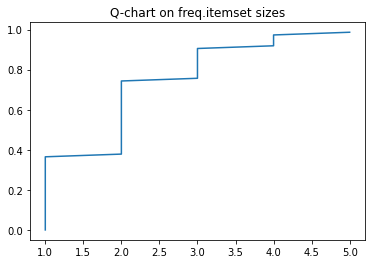

In [7]:
itemset_lens = [len(i) for i in close_freqitems]
plot_qchart(itemset_lens,'Q-chart on freq.itemset sizes')

可见绝大多数频繁项集都是1项、2项的，少数具有3-4个元素。个别的频繁项集具有5个元素，不存在涉及更多元素的频繁项集。

## 3 导出关联规则

使用频繁项集来导出关联规则。定义最低置信度，并且筛选出满足置信度要求的关联规则。

首先，我们定义关联规则的数据结构。这个数据结构存储规则的两边以及原始的项集，同时存储support信息和confidence。

In [8]:
# 定义关联规则的数据结构
class Rule:
    def __init__(self,itemset,head):
        assert head in itemset
        self.head = head
        self.items = tuple(itemset)
        self.to = tuple(sorted([i for i in itemset if i != head]))
        # 这里的support存储的是绝对支持度
        self.head_support = sup[(head,)]
        self.support = sup[itemset]
        self.confidence = self.support/self.head_support
        assert self.confidence <=1
        self.lift=None

之后，我们遍历项目集，找出所有满足最低置信度要求的关联规则。

提取出114条关联规则，其置信度分布如下图所示：


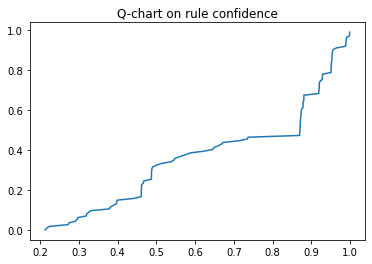

In [9]:
min_confidence = 0.2
rules:list[Rule]=[]
for itemset in close_freqitems:
    if len(itemset)<2: continue
    for head in itemset:
        newrule = Rule(itemset,head)
        if newrule.confidence>=min_confidence:
            rules.append(newrule)
print(f'提取出{len(rules)}条关联规则，其置信度分布如下图所示：')
confidences=[rule.confidence for rule in rules]
plot_qchart(confidences,'Q-chart on rule confidence')

与之前的Q图相同，此Q图的横坐标是置信度，纵坐标是对应置信度在整体中的比例。注意到有约一半关联规则的置信度在85%以上，约1/4的关联规则置信度在90%以上。下面展示这些置信度在90%以上的关联规则。这些关联规则都是用违规条目的ID表示的，我们在后面附上ID对应的编码和解释。

In [10]:
viol_tobe_explained=set()
rules_ptd = [rule for rule in rules if rule.confidence>=0.9]
rules_ptd.sort(key = lambda rule:rule.confidence,reverse=True)
print(f'total {len(rules_ptd)} rules to be shown:')
print(f'{"Confidence":<12}{"Set Sup.":<12}Head  Tail')
for rule in rules_ptd:
        viol_tobe_explained.update(rule.items)
        print(f'{rule.confidence:<12.5f}{rule.support/bld_count:<12.5f}{rule.head:<6}{rule.to}')

total 36 rules to be shown:
Confidence  Set Sup.    Head  Tail
0.99867     0.09255     124   (131,)
0.99846     0.09253     124   (136,)
0.99825     0.09251     124   (131, 136)
0.99055     0.09259     136   (131,)
0.98993     0.09253     136   (124,)
0.98972     0.09251     136   (124, 131)
0.98911     0.09259     131   (136,)
0.98869     0.09255     131   (124,)
0.98828     0.09251     131   (124, 136)
0.96390     0.08252     139   (159,)
0.95563     0.08181     139   (131,)
0.95479     0.08174     139   (136,)
0.95366     0.08164     139   (131, 136)
0.95335     0.08161     139   (124,)
0.95320     0.08160     139   (124, 131)
0.95305     0.08159     139   (124, 136)
0.95297     0.08158     139   (124, 131, 136)
0.95168     0.08147     139   (131, 159)
0.95146     0.08145     139   (136, 159)
0.95115     0.08142     139   (131, 136, 159)
0.95108     0.08142     139   (124, 159)
0.95100     0.08141     139   (124, 131, 159)
0.95085     0.08140     139   (124, 136, 159)
0.95077     0.

In [11]:
print('每个违规项目ID的代码和解释：')
print(f"{'ID':<6}{'代码':<12}解释")
for viol in viol_tobe_explained:
        print(f'{viol:<6}{viol2code[viol]:<12}{viol2desp[viol]}')

每个违规项目ID的代码和解释：
ID    代码          解释
131   CN193019    REPAIR/WRECK DANGER RESID PREM
136   CN193000    MAINTAN BLDG IN SAFE CONDITION
139   CN196039    POST OWNER INFO ON ABDN BLDG
124   CN193029    WATCHMAN
159   CN193110    VACANT BUILDING - REGISTER


我们得以从中知晓一些信息，如CN193029（WATCHMAN）、CN193000（MAINTAN BLDG IN SAFE CONDITION）和CN193019（REPAIR/WRECK DANGER RESID PREM）几乎总是同时出现，而且这些房屋还是有一定占比的（约为8%-9%）。接下来，我们对这些关联规则进行评价。

## 4 关联规则的评价

### 4.1 Lift评价指标

之前定义的Rule数据结构中包含的信息足以支撑我们计算每一个关联规则头到尾的Lift。我们进行计算，并且给出分布情况。

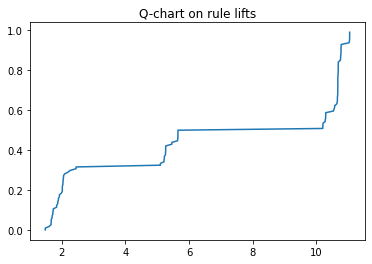

In [12]:
lifts=[]
for rule in rules:
    head_sup = rule.head_support/bld_count
    total_sup = rule.support/bld_count
    tail_sup = sup[rule.to]/bld_count
    rule.lift = total_sup/(head_sup*tail_sup)
    lifts.append(total_sup/(head_sup*tail_sup))
plot_qchart(lifts,'Q-chart on rule lifts')

一些规则的lift还是非常高的。接下来我们来看规则的置信度到lift的Q-Q图：

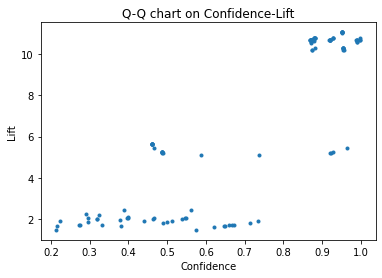

In [13]:
def plot_qq_chart(x,y,xlabel,ylabel,title):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    decorated = sorted(zip(x,y),key=lambda t:t[0])
    plt.plot([d[0]for d in decorated],[d[1] for d in decorated],'.')
    plt.show()

plot_qq_chart(confidences,lifts,"Confidence",'Lift','Q-Q chart on Confidence-Lift')


lift和置信度一定程度上是成正相关的，但相比置信度，lift明显分成了三档，一档位于2左右，一档位于6左右，一档位于10左右。

### 4.2 AllConf评价指标

与Lift指标不同，AllConf指标对不相关的记录是不敏感的。考虑到频繁项集中的很多项支持度都不是很高，AllConf可以给出受到数据集中众多无关记录影响较小，从而更加客观的评价指标。

下面我们求各个关联规则的AllConf评标，并将其与置信度和Lift做对比。

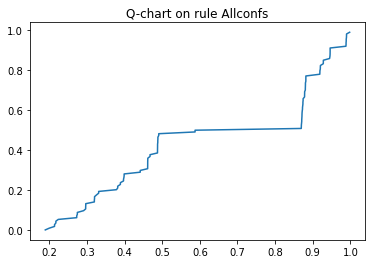

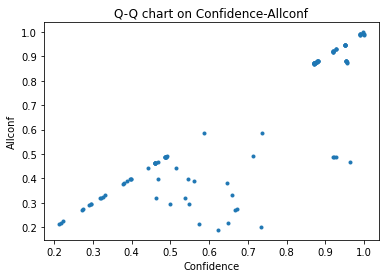

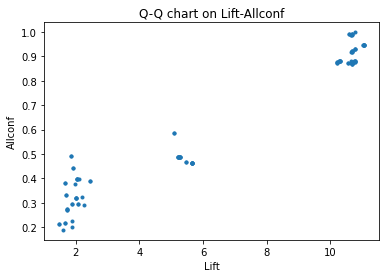

In [14]:
allConfs = []
for rule in rules:
    head_sup = rule.head_support/bld_count
    total_sup = rule.support/bld_count
    tail_sup = sup[rule.to]/bld_count
    allConfs.append(total_sup/max(head_sup,tail_sup))
plot_qchart(allConfs,'Q-chart on rule Allconfs')
plot_qq_chart(confidences,allConfs,'Confidence','Allconf','Q-Q chart on Confidence-Allconf')
plot_qq_chart(lifts,allConfs,'Lift','Allconf','Q-Q chart on Lift-Allconf')

我们对上述结果进行分析。

AllConf的数量分布与Lift的分布很相似，后续AllConf-Lift的Q-Q图证实了这一点。Lift的分布比Allconf的分布更加离散，明显分成三个部分，而在Allconf这里前两个部分是混合在一起的。同时注意到，Lift低而置信度相对较高的一些关联规则，其AllConf变得低了，与Lift接近。

再看置信度到Allconf的Q-Q图。大部分关联规则都落在y=x这一直线上，这是显然的：对任意一个项目集，任取出一个项目组成头、剩下的项目组成尾，都可以组成一个关联规则。对于从两个项目组成的项目集中导出的两个关联规则，其中一个必然满足Confidence=Allconf；考虑三个及以上项目组成的项目集中的关联规则，尾部由于含有多个项目，support往往小于等于单一项目的support。  
事实上也可以证明，项目集中至少可以导出一个满足AllConf=Confidence的关联规则：只需取项目集中support最大的项目作为头部，其余项目作为尾部即可。这样，尾部的总support必然小于等于其各个项目自身的support，从而小于等于头部的support，因此这个关联规则的Allconf=confidence。

因此，我们可以在不丢弃任何项目集的情况下，丢弃掉Allconf\<Confidence的关联规则。剩余的关联规则，Allconf必然与置信度相等。

In [19]:
pruned_rules = []
pruned_confidences = []
pruned_lifts = []

for rule,confidence,allconf,lift in zip(rules,confidences,allConfs,lifts):
    #if confidence == allconf:
    if allconf / confidence >= 0.99:    #为了防止计算误差，我们不要求严格相等
        pruned_rules.append(rule)
        pruned_confidences.append(confidence)
        pruned_lifts.append(lift)

丢弃后，剩余关联规则的数量：

In [20]:
len(pruned_rules)

85

丢弃掉allconf较置信度低的关联规则后，先前提取出的114个关联规则剩余85个。我们重新来看它们的置信度和lift分布：

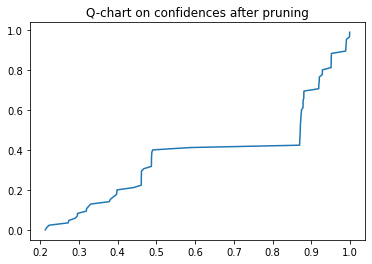

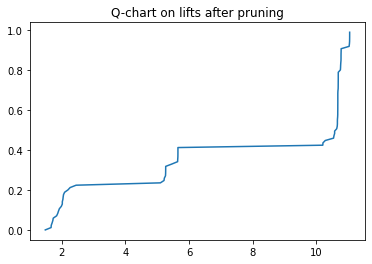

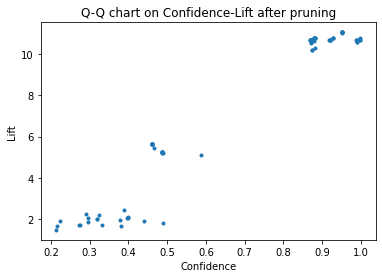

In [21]:
plot_qchart(pruned_confidences,'Q-chart on confidences after pruning')
plot_qchart(pruned_lifts,'Q-chart on lifts after pruning')
plot_qq_chart(pruned_confidences,pruned_lifts,'Confidence','Lift','Q-Q chart on Confidence-Lift after pruning')

经过这种剪除以后，可见剩余的关联规则置信度和lift均有上升，其中置信度高于90%的关联规则占到了一半以上，而这些关联规则的lift均高于10。可见剪除后剩余规则的质量变高了。